In [1]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget
!pip install mdatagen
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget
!pip install numpy scipy sklearn
!pip install jax
!pip install chex
!pip install attr
!pip install optax



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
#from DataSetLoader import dataset_loader, ground_truth
from SinkhornImputation import SinkhornImputation
from Sinkhorn_CMI import *
from RR_imputer import RRimputer
import matplotlib.pyplot as plt
from CMI import *

from Inject_Missing_Values import *

from Miss import *

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")
import pandas as pd

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


**Load Data**

In [ ]:
import pandas as pd

# Read CSV file into a Pandas DataFrame
groundTruth = pd.read_csv(r'C:\Users\zhossai3\Desktop\My code\OT_Fairness\Data\German Credit\German_Credit_Ground_Truth.csv', delimiter=',', header=0)

# Store feature columns in a DataFrame


X= groundTruth.iloc[:, :-1]  # Selects all rows and all columns except the last one
Y = groundTruth.iloc[:, -1]  # Selects all rows and only the last column


In [ ]:
groundTruth_tensor = torch.tensor(scale(groundTruth)) #converting groundTruth to Tensor, z-score scaling

In [ ]:
bucket_specs = {
     
    11: 4,   # Column 11 → age (4 bins)
    19: 2,  # Column 19 → sex (2 bins)
    21: 2,  # Column 21 → label  (2 bins)
    5: 5,   # Column 5 → savings-account (5 bins)
    15: 4   # Column 15 → jobs (4 bins)
}

# Define multiple attributes for X, Y, Z
X_cols = [11,19]  # Bucketized sensitive attributes (e.g., sex, race, age)
Y_cols = [21]     # Bucketized outcome-related attributes
Z_cols = [5, 15]  

**CMI for GroundTruth**

In [ ]:
cmi_groundTruth = CMI.conditional_mutual_information(groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
print(cmi_groundTruth)

0.06860055029392242


MCAR 30%

In [ ]:
generator = Inject_Missing_Values()
miss_mcar30,index_mcar30 = generator.MCAR(X,missing_rate=30)
type(miss_mcar30)
miss_mcar30 = pd.concat([miss_mcar30, Y], axis=1) #adding the target coloumn

In [ ]:
miss_mcar30_numpy = scale(miss_mcar30) #z-score scaling
miss_mcar30_tensor = torch.tensor(miss_mcar30_numpy) #converting to tensor

In [ ]:
#only Sinkhorn
n_mcar30, d_mcar30 = miss_mcar30_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar30 = pick_epsilon(miss_mcar30_tensor)
print(epsilon_mcar30)
mask_mcar30= torch.isnan(miss_mcar30_tensor).double()


on_sk_imputer_mcar30 = SinkhornImputation(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
on_sk_imp_mcar30, on_sk_maes30mcar, on_sk_rmses30mcar = on_sk_imputer_mcar30.fit_transform(miss_mcar30_tensor, verbose=True, report_interval=50, X_true=groundTruth_tensor)

#using numpy version of data
on_sk_imp_mcar30_numpy = on_sk_imp_mcar30.detach().cpu().numpy()
on_sk_mae_mcar30 = MAE(on_sk_imp_mcar30,groundTruth_tensor , mask_mcar30)
on_sk_rmse_mcar30 = RMSE(on_sk_imp_mcar30, groundTruth_tensor, mask_mcar30)
print(on_sk_mae_mcar30,on_sk_rmse_mcar30)

0.7254574155885616


INFO:root:batchsize = 128, epsilon = 0.7255
INFO:root:Iteration 0:	 Loss: 5.4126	 Validation MAE: 0.7720	RMSE: 1.0010
INFO:root:Iteration 50:	 Loss: 5.0876	 Validation MAE: 0.7035	RMSE: 0.9848
INFO:root:Iteration 100:	 Loss: 5.9681	 Validation MAE: 0.6925	RMSE: 0.9801
INFO:root:Iteration 150:	 Loss: 5.2818	 Validation MAE: 0.6868	RMSE: 0.9776
INFO:root:Iteration 200:	 Loss: 6.0660	 Validation MAE: 0.6827	RMSE: 0.9771
INFO:root:Iteration 250:	 Loss: 5.7016	 Validation MAE: 0.6787	RMSE: 0.9748
INFO:root:Iteration 300:	 Loss: 5.5944	 Validation MAE: 0.6773	RMSE: 0.9753
INFO:root:Iteration 350:	 Loss: 5.2720	 Validation MAE: 0.6760	RMSE: 0.9755
INFO:root:Iteration 400:	 Loss: 5.4697	 Validation MAE: 0.6760	RMSE: 0.9764
INFO:root:Iteration 450:	 Loss: 5.6203	 Validation MAE: 0.6763	RMSE: 0.9772
INFO:root:Iteration 500:	 Loss: 5.2210	 Validation MAE: 0.6772	RMSE: 0.9778
INFO:root:Iteration 550:	 Loss: 4.8926	 Validation MAE: 0.6778	RMSE: 0.9791
INFO:root:Iteration 600:	 Loss: 5.1786	 Validat

tensor(0.6795, grad_fn=<DivBackward0>) tensor(0.9855, grad_fn=<SqrtBackward0>)


CMI only for Sinkhorn Imputation

In [ ]:
#only CMI
on_cmi_missmcar30 = CMI.conditional_mutual_information(on_sk_imp_mcar30, X_cols, Y_cols, Z_cols, bucket_specs)
print(on_cmi_missmcar30)
print(on_sk_mae_mcar30,on_sk_rmse_mcar30)

0.06550872325897217
tensor(0.6795, grad_fn=<DivBackward0>) tensor(0.9855, grad_fn=<SqrtBackward0>)


In [ ]:
#sinkhorn_CMI
n_mcar30, d_mcar30 = miss_mcar30_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar30 = pick_epsilon(miss_mcar30_tensor)
#epsilon_mcar30 = 0.3
print(epsilon_mcar30)
mask_mcar30= torch.isnan(miss_mcar30_tensor).double()


sk_imputer_mcar30 = SinkhornImputation_CMI(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes30mcar, sk_rmses30mcar,cmi_loss = sk_imputer_mcar30.fit_transform(miss_mcar30_tensor, True, 50, groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
#using numpy version of data
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()

sk_mae_mcar30 = MAE(sk_imp_mcar30,groundTruth_tensor , mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30, groundTruth_tensor, mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)





0.7254574155885616


INFO:root:Iteration 0:	 Loss: 5.2638	 Validation MAE: 0.7743	RMSE: 1.0026
INFO:root:Iteration 50:	 Loss: 5.1818	 Validation MAE: 0.7060	RMSE: 0.9877
INFO:root:Iteration 100:	 Loss: 5.5007	 Validation MAE: 0.6939	RMSE: 0.9832
INFO:root:Iteration 150:	 Loss: 5.5643	 Validation MAE: 0.6869	RMSE: 0.9795
INFO:root:Iteration 200:	 Loss: 5.2907	 Validation MAE: 0.6836	RMSE: 0.9788
INFO:root:Iteration 250:	 Loss: 5.2610	 Validation MAE: 0.6813	RMSE: 0.9774
INFO:root:Iteration 300:	 Loss: 5.3274	 Validation MAE: 0.6788	RMSE: 0.9757
INFO:root:Iteration 350:	 Loss: 5.8036	 Validation MAE: 0.6762	RMSE: 0.9749
INFO:root:Iteration 400:	 Loss: 6.1528	 Validation MAE: 0.6757	RMSE: 0.9742
INFO:root:Iteration 450:	 Loss: 6.0176	 Validation MAE: 0.6749	RMSE: 0.9745
INFO:root:Iteration 500:	 Loss: 5.2030	 Validation MAE: 0.6743	RMSE: 0.9745
INFO:root:Iteration 550:	 Loss: 5.5556	 Validation MAE: 0.6739	RMSE: 0.9745
INFO:root:Iteration 600:	 Loss: 5.9868	 Validation MAE: 0.6730	RMSE: 0.9744
INFO:root:Itera

tensor(0.6779, grad_fn=<DivBackward0>) tensor(0.9831, grad_fn=<SqrtBackward0>)


CMI for Sinkhorn_CMI Imputation

In [ ]:
#CMI
cmi_mcar30 = CMI.conditional_mutual_information(sk_imp_mcar30, X_cols, Y_cols, Z_cols, bucket_specs)
print(cmi_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

0.07461120933294296
tensor(0.6779, grad_fn=<DivBackward0>) tensor(0.9831, grad_fn=<SqrtBackward0>)


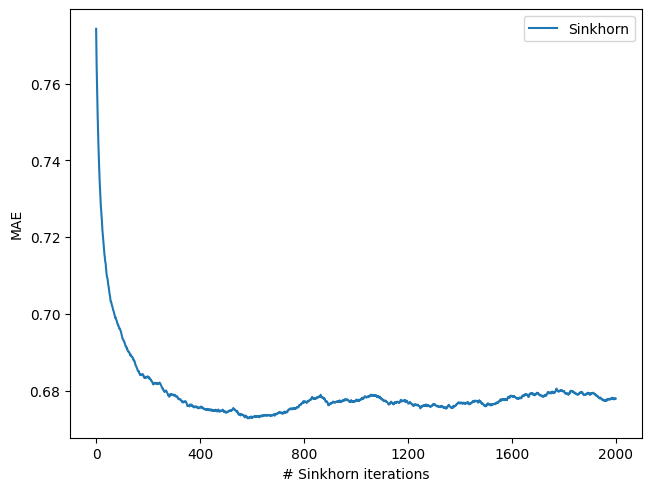

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes30mcar)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes30mcar, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')
ax.set_ylabel('MAE')
plt.legend()
plt.show()

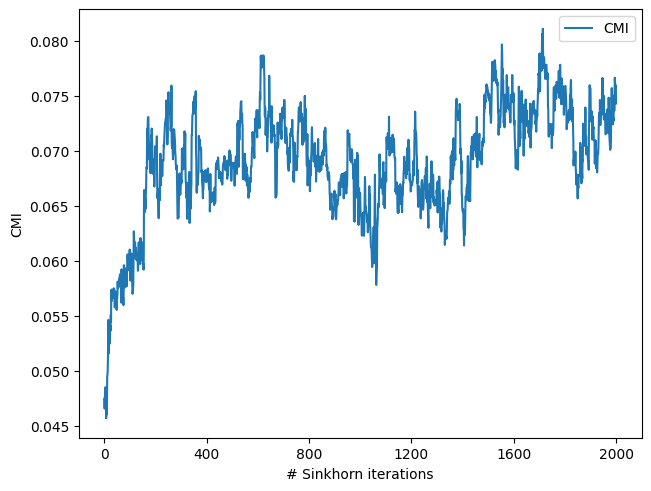

In [ ]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(cmi_loss)

ax.plot(np.linspace(0, 1, npoints) * npoints, cmi_loss, label='CMI')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.set_ylabel('CMI')
plt.legend()
plt.show()

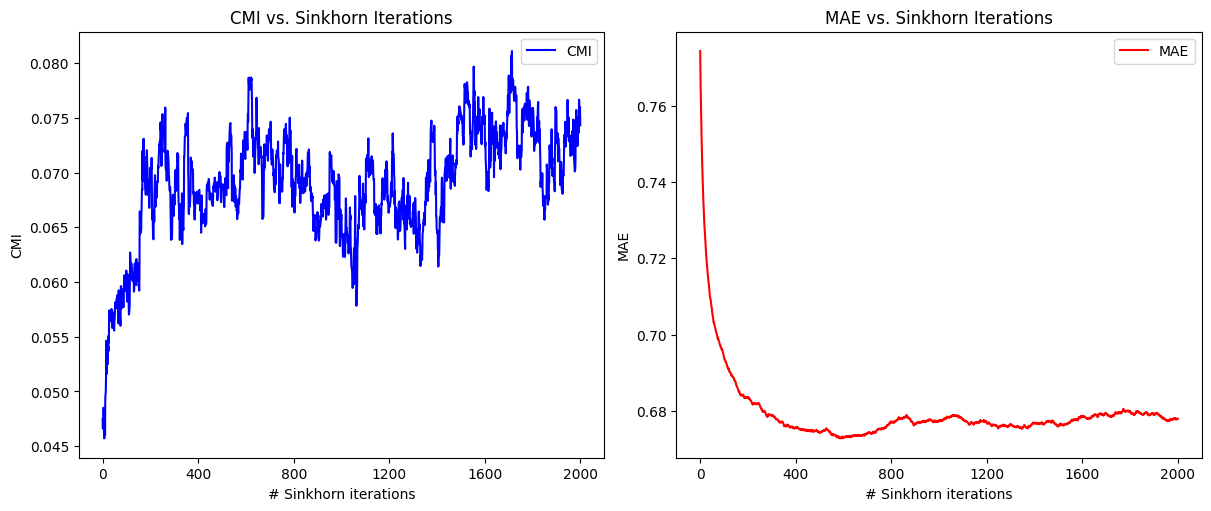

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (Replace with actual values)
npoints_cmi = len(cmi_loss)  # Length of CMI data
npoints_mae = len(sk_maes30mcar)  # Length of MAE data

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# First graph (CMI)
axes[0].plot(np.linspace(0, 1, npoints_cmi) * npoints_cmi, cmi_loss, label='CMI', color='b')
axes[0].set_xticks(np.linspace(0, npoints_cmi, 6))
axes[0].set_xlabel('# Sinkhorn iterations')
axes[0].set_ylabel('CMI')
axes[0].legend()
axes[0].set_title('CMI vs. Sinkhorn Iterations')

# Second graph (MAE)
axes[1].plot(np.linspace(0, 1, npoints_mae) * npoints_mae, sk_maes30mcar, label='MAE', color='r')
axes[1].set_xticks(np.linspace(0, npoints_mae, 6))
axes[1].set_xlabel('# Sinkhorn iterations')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_title('MAE vs. Sinkhorn Iterations')

# Show the combined plot
plt.show()


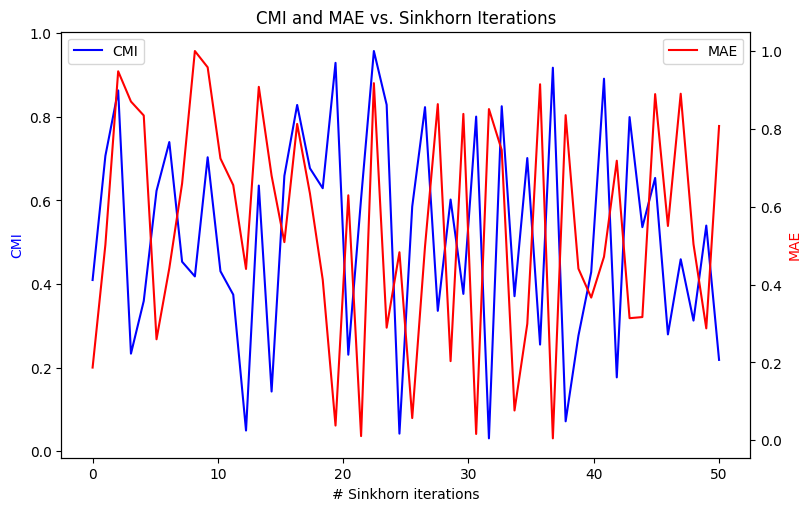

In [ ]:
# Re-import necessary libraries after execution state reset
import matplotlib.pyplot as plt
import numpy as np

# Sample data (Replace with actual values)
cmi_loss = np.random.rand(50)  # Example data for CMI
sk_maes30mcar = np.random.rand(50)  # Example data for MAE

npoints = max(len(cmi_loss), len(sk_maes30mcar))  # Use the max length to align both plots

# Create figure
fig, ax = plt.subplots(figsize=(8, 5), constrained_layout=True)

# Plot CMI (left y-axis)
ax.plot(np.linspace(0, 1, len(cmi_loss)) * len(cmi_loss), cmi_loss, label='CMI', color='b')

# Create second y-axis for MAE
ax2 = ax.twinx()
ax2.plot(np.linspace(0, 1, len(sk_maes30mcar)) * len(sk_maes30mcar), sk_maes30mcar, label='MAE', color='r')

# Formatting axes
ax.set_xlabel('# Sinkhorn iterations')
ax.set_ylabel('CMI', color='b')
ax2.set_ylabel('MAE', color='r')

# Legends
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot
plt.title("CMI and MAE vs. Sinkhorn Iterations")
plt.show()


In [ ]:
# Find the best trade-off index using the heuristic
best_tradeoff_idx = np.argmin(sk_maes30mcar + cmi_loss)

# Get the corresponding values
best_cmi = cmi_loss[best_tradeoff_idx]
best_mae = sk_maes30mcar[best_tradeoff_idx]

# Display the best trade-off values
best_tradeoff_idx, best_cmi, best_mae


(np.int64(33),
 np.float64(0.37086510802650596),
 np.float64(0.07631150684452481))

**30% MAR**

In [ ]:
dependencies_mar30 = {"savings-account": {
        "influencers": ["age"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.8 if row["age"]<=25 else 0.2 
    },
    "checking-account": {
        "influencers": ["age"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.8 if row["age"]<=25 else 0.2 
    },
    "credit-amount": {
        "influencers": ["age"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.8 if row["age"]<=25 else 0.2 
    },
    "employment-since": {
        "influencers": ["sex"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.8 if row["sex"]==1 else 0.2 
    },
    "duration": {
        "influencers": ["sex"],
        "condition": lambda row: True,  # Just a boolean condition
        "probability" : lambda row: 0.8 if row["sex"]==1 else 0.2 
    }
}

In [ ]:
generator_mar30 = Inject_Missing_Values()
miss_mar30,index_mar30 = generator_mar30.MAR(X,dependencies_mar30,missing_rate=30)
miss_mar30 = pd.concat([miss_mar30, Y], axis=1) #adding the target coloumn

total_missing_percentage_mar30= miss_mar30.isnull().sum().sum() / miss_mar30.size * 100
print(f"Total Missing Percentage MAR30: {total_missing_percentage_mar30:.2f}%")

In [ ]:
miss_mar30_numpy = scale(miss_mar30) #z-score scaling
miss_mar30_tensor = torch.tensor(miss_mar30_numpy) #converting to tensor

In [ ]:
#only Sinkhorn
n_mar30, d_mar30 = miss_mar30_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mar30 = pick_epsilon(miss_mar30_tensor)
print(epsilon_mar30)
mask_mar30= torch.isnan(miss_mar30_tensor).double()


on_sk_imputer_mar30 = SinkhornImputation(eps=epsilon_mar30, batchsize=batchsize, lr=lr, niter=2000)
on_sk_imp_mar30, on_sk_maes30mar, on_sk_rmses30mar = on_sk_imputer_mar30.fit_transform(miss_mar30_tensor, verbose=True, report_interval=50, X_true=groundTruth_tensor)

#using numpy version of data
on_sk_imp_mar30_numpy = on_sk_imp_mar30.detach().cpu().numpy()
on_sk_mae_mar30 = MAE(on_sk_imp_mar30,groundTruth_tensor , mask_mar30)
on_sk_rmse_mar30 = RMSE(on_sk_imp_mar30, groundTruth_tensor, mask_mar30)
print(on_sk_mae_mar30,on_sk_rmse_mar30)

In [ ]:
#only CMI
on_cmi_missmar30 = CMI.conditional_mutual_information(on_sk_imp_mar30, X_cols, Y_cols, Z_cols, bucket_specs)
print(on_cmi_missmar30)
print(on_sk_mae_mar30,on_sk_rmse_mar30)

In [ ]:
#sinkhorn_CMI
n_mar30, d_mar30 = miss_mar30_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mar30 = pick_epsilon(miss_mar30_tensor)
#epsilon_mcar30 = 0.3
print(epsilon_mar30)
mask_mar30= torch.isnan(miss_mar30_tensor).double()


sk_imputer_mar30 = SinkhornImputation_CMI(eps=epsilon_mar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mar30, sk_maes30mar, sk_rmses30mar,cmi_loss_mar30 = sk_imputer_mar30.fit_transform(miss_mar30_tensor, True, 50, groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
#using numpy version of data
sk_imp_mar30_numpy = sk_imp_mar30.detach().cpu().numpy()

sk_mae_mar30 = MAE(sk_imp_mar30,groundTruth_tensor , mask_mar30)
sk_rmse_mar30 = RMSE(sk_imp_mar30, groundTruth_tensor, mask_mar30)
print(sk_mae_mar30,sk_rmse_mar30)


In [ ]:
#CMI
cmi_mar30 = CMI.conditional_mutual_information(sk_imp_mar30, X_cols, Y_cols, Z_cols, bucket_specs)
print(cmi_mar30)
print(sk_mae_mar30,sk_rmse_mar30)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (Replace with actual values)
npoints_cmi = len(cmi_loss_mar30)  # Length of CMI data
npoints_mae = len(sk_maes30mar)  # Length of MAE data

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# First graph (CMI)
axes[0].plot(np.linspace(0, 1, npoints_cmi) * npoints_cmi, cmi_loss_mar30, label='CMI', color='b')
axes[0].set_xticks(np.linspace(0, npoints_cmi, 6))
axes[0].set_xlabel('# Sinkhorn iterations')
axes[0].set_ylabel('CMI')
axes[0].legend()
axes[0].set_title('CMI vs. Sinkhorn Iterations')

# Second graph (MAE)
axes[1].plot(np.linspace(0, 1, npoints_mae) * npoints_mae, sk_maes30mar, label='MAE', color='r')
axes[1].set_xticks(np.linspace(0, npoints_mae, 6))
axes[1].set_xlabel('# Sinkhorn iterations')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_title('MAE vs. Sinkhorn Iterations')

# Show the combined plot
plt.show()


**30% MNAR**

In [ ]:
dependencies_mnar30 = {
    "checking-account": {
        "influencers": ["checking-account"],
         "condition": lambda row: True,
        "probability": lambda row: 0.25 if row["checking-account"] == 0 else 0.05
    },
    "duration": {
        "influencers": ["duration"],
        "condition": lambda row: True,
        "probability": lambda row: 0.25 if row["duration"] <= 20 else 0.05
    },
    "savings-account": {
        "influencers": ["savings-account"],
        "condition": lambda row: True,
        "probability": lambda row: 0.2 if row["savings-account"] != 0 else 0.1
    },
    "employment-since": {
        "influencers": ["employment-since"],
         "condition": lambda row: True,
        "probability": lambda row: 0.2 if row["employment-since"] in [1,2] else 0.1
    },
    "credit-amount": {
        "influencers": ["credit-amount"],
         "condition": lambda row: True,
        "probability": lambda row: 0.25 if row["credit-amount"] > 5000 else 0.05
    }
}

In [ ]:
generator_mnar30 = Inject_Missing_Values()
miss_mnar30,index_mnar30 = generator_mnar30.MNAR(X,dependencies_mnar30,missing_rate=30)

miss_mnar30 = pd.concat([miss_mnar30, Y], axis=1) #adding the target coloumn

total_missing_percentage_mnar30= miss_mnar30.isnull().sum().sum() / miss_mnar30.size * 100
print(f"Total Missing Percentage MNAR30: {total_missing_percentage_mnar30:.2f}%")

In [ ]:
miss_mnar30_numpy = scale(miss_mnar30) #z-score scaling
miss_mnar30_tensor = torch.tensor(miss_mnar30_numpy) #converting to tensor

In [ ]:
#only Sinkhorn
n_mnar30, d_mnar30 = miss_mnar30_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mnar30 = pick_epsilon(miss_mnar30_tensor)
print(epsilon_mnar30)
mask_mnar30= torch.isnan(miss_mnar30_tensor).double()


on_sk_imputer_mnar30 = SinkhornImputation(eps=epsilon_mnar30, batchsize=batchsize, lr=lr, niter=2000)
on_sk_imp_mnar30, on_sk_maes30mnar, on_sk_rmses30mnar = on_sk_imputer_mnar30.fit_transform(miss_mnar30_tensor, verbose=True, report_interval=50, X_true=groundTruth_tensor)

#using numpy version of data
on_sk_imp_mnar30_numpy = on_sk_imp_mnar30.detach().cpu().numpy()
on_sk_mae_mnar30 = MAE(on_sk_imp_mnar30,groundTruth_tensor , mask_mnar30)
on_sk_rmse_mnar30 = RMSE(on_sk_imp_mnar30, groundTruth_tensor, mask_mnar30)
print(on_sk_mae_mnar30,on_sk_rmse_mnar30)

In [ ]:
#only CMI
on_cmi_missmnar30 = CMI.conditional_mutual_information(on_sk_imp_mnar30, X_cols, Y_cols, Z_cols, bucket_specs)
print(on_cmi_missmnar30)
print(on_sk_mae_mnar30,on_sk_rmse_mnar30)

In [ ]:
#sinkhorn_CMI
n_mnar30, d_mnar30 = miss_mnar30_tensor.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mnar30 = pick_epsilon(miss_mnar30_tensor)
#epsilon_mcar30 = 0.3
print(epsilon_mnar30)
mask_mnar30= torch.isnan(miss_mnar30_tensor).double()


sk_imputer_mnar30 = SinkhornImputation_CMI(eps=epsilon_mnar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mnar30, sk_maes30mnar, sk_rmses30mnar,cmi_loss_mnar30 = sk_imputer_mnar30.fit_transform(miss_mnar30_tensor, True, 50, groundTruth_tensor, X_cols, Y_cols, Z_cols, bucket_specs)
#using numpy version of data
sk_imp_mnar30_numpy = sk_imp_mnar30.detach().cpu().numpy()

sk_mae_mnar30 = MAE(sk_imp_mnar30,groundTruth_tensor , mask_mnar30)
sk_rmse_mnar30 = RMSE(sk_imp_mnar30, groundTruth_tensor, mask_mnar30)
print(sk_mae_mnar30,sk_rmse_mnar30)





In [ ]:
#CMI
cmi_mnar30 = CMI.conditional_mutual_information(sk_imp_mnar30, X_cols, Y_cols, Z_cols, bucket_specs)
print(cmi_mnar30)
print(sk_mae_mnar30,sk_rmse_mnar30)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (Replace with actual values)
npoints_cmi = len(cmi_loss_mnar30)  # Length of CMI data
npoints_mae = len(sk_maes30mnar)  # Length of MAE data

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# First graph (CMI)
axes[0].plot(np.linspace(0, 1, npoints_cmi) * npoints_cmi, cmi_loss_mnar30, label='CMI', color='b')
axes[0].set_xticks(np.linspace(0, npoints_cmi, 6))
axes[0].set_xlabel('# Sinkhorn iterations')
axes[0].set_ylabel('CMI')
axes[0].legend()
axes[0].set_title('CMI vs. Sinkhorn Iterations')

# Second graph (MAE)
axes[1].plot(np.linspace(0, 1, npoints_mae) * npoints_mae, sk_maes30mnar, label='MAE', color='r')
axes[1].set_xticks(np.linspace(0, npoints_mae, 6))
axes[1].set_xlabel('# Sinkhorn iterations')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_title('MAE vs. Sinkhorn Iterations')

# Show the combined plot
plt.show()
